In [1]:
# Load libraries and functions
%load_ext autoreload
%autoreload 2
%matplotlib inline
RANDOM_STATE = 42  # Pseudo-random state

from utils import *
sns.set_palette("tab10") # Default seaborn theme

# Extra libraries for this notebook
import cmprsk
from cmprsk import utils
from cmprsk.cmprsk import cuminc

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# Upload dataset
fn_vae_data = glob.glob('./data/Updated*.pkl')
latest_fn_vae_data = max(fn_vae_data, key=os.path.getctime)

print("Loading... ",latest_fn_vae_data)
with open(latest_fn_vae_data, "rb") as f:
    vae_data_main = pickle.load(f)
print("Done")

Loading...  ./data/Updated_VAE_Data_Main_0821_0932.pkl
Done


# Risk of HARTI depending on ICU days

stats:  False


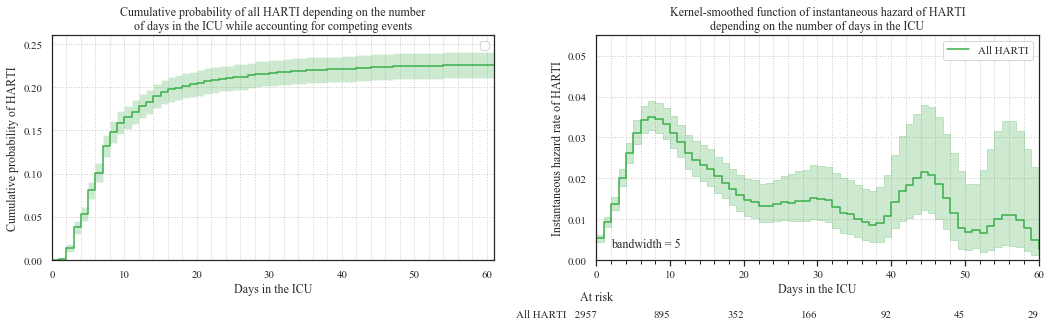

In [3]:
### All HARTI

# Define data
T = vae_data_main[['ID_subid', 'day_in_icu_bid']].groupby('ID_subid').max()
E = vae_data_main[['ID_subid', 'infection_respiratory']].groupby('ID_subid').max()

# Plot hazard function
BANDWIDTH = 5
LIM = 61
colors_sns = ['medium green']
sns.set_palette(sns.xkcd_palette(colors_sns))
fig, [ax, ax1] = plt.subplots(1, 2, figsize=(15,5))
naf = NelsonAalenFitter()
naf.fit(T, E, timeline=range(0, LIM, 1), label='All HARTI')

naf.plot_hazard(ax=ax1, bandwidth=BANDWIDTH)
add_at_risk_counts(naf, ax=ax1)
ax1.text(2, 0.003, 'bandwidth = '+ "%.0f" %BANDWIDTH, fontsize=12)
ax1.minorticks_on()
ax1.grid(linestyle='dotted', which='both', axis='x')
ax1.grid(linestyle='dotted')
ax1.set_ylim(0, 0.055)
ax1.set_ylabel('Instantaneous hazard rate of HARTI')
ax1.set_xlabel('Days in the ICU')
ax1.set_title('Kernel-smoothed function of instantaneous hazard of HARTI\ndepending on the number of days in the ICU')


# Plot competing event function
E = E.replace(0, 2)
cuminc_res = cuminc(T.values.reshape(-1), E.values.reshape(-1))

for name, group in list(cuminc_res.groups.items())[:1]:
    ax.plot(group.time, group.est, label=name)
    ax.fill_between(group.time, group.low_ci, group.high_ci, alpha=0.25)
    ax.set_xlim(0, LIM, 1)

ax.set_ylim(0, 0.26)
ax.minorticks_on()
ax.grid(linestyle='dotted', which='both', axis='x')
ax.grid(linestyle='dotted')
ax.legend('')
ax.set_ylabel('Cumulative probability of HARTI')
ax.set_xlabel('Days in the ICU')
ax.set_title('Сumulative probability of all HARTI depending on the number\nof days in the ICU while accounting for competing events')
plt.tight_layout()
plt.savefig('./pictures/cuminc_all_days.pdf', dpi=600)

sns.set_palette("tab10") # Default seaborn theme

In [4]:
# Show estimate table from cuminc
df = []
for name, group in cuminc_res.groups.items():
    df.append(group.time)
    df.append(group.est)
    df.append(name)
    
harti = pd.DataFrame(zip(pd.Series(df[0]), pd.Series(df[1])))
pd.set_option('display.max_rows', len(harti))
print(harti.tail(10))

# Added risk at first 10 days
h10 = harti.iloc[1:16, :]
print('\nEach day adds probability: ', h10.diff().mean().values)

         0         1
96    62.0  0.226243
97    70.0  0.226243
98    70.0  0.226581
99    74.0  0.226581
100   74.0  0.226919
101  144.0  0.226919
102  144.0  0.227257
103  192.0  0.227257
104  192.0  0.227596
105  365.0  0.227596

Each day adds probability:  [0.5        0.00942074]


/usr/local/lib/python3.7/site-packages/lifelines/fitters/nelson_aalen_fitter.py:258: RuntimeWarning: invalid value encountered in true_divide
  self.ci_labels[0]: hazard_ * np.exp(z * std_hazard_ / hazard_),
/usr/local/lib/python3.7/site-packages/lifelines/fitters/nelson_aalen_fitter.py:259: RuntimeWarning: invalid value encountered in true_divide
  self.ci_labels[1]: hazard_ * np.exp(-z * std_hazard_ / hazard_),


stats:  False
stats:  False


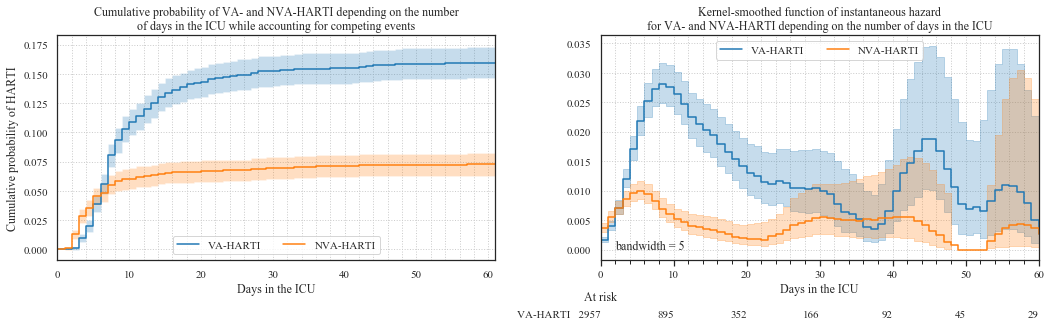

In [5]:
#### VA- and NVA-HARTI separately

# Define data
T = vae_data_main[['ID_subid', 'day_in_icu_bid']].groupby('ID_subid').max()
E1 = vae_data_main[['ID_subid', 'vap']].groupby('ID_subid').max()
E2 = vae_data_main[['ID_subid', 'non_vap_resp_hai']].groupby('ID_subid').max()

# Plot hazard function
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15,5))
BANDWIDTH = 5
LIM = 61
naf1 = NelsonAalenFitter()
naf1.fit(T, E1, timeline=range(0, LIM, 1), label='VA-HARTI')
naf1.plot_hazard(ax=ax2, bandwidth=BANDWIDTH)
add_at_risk_counts(naf1, ax=ax2)

naf2 = NelsonAalenFitter()
naf2.fit(T, E2, timeline=range(0, LIM, 1), label='NVA-HARTI')
naf2.plot_hazard(ax=ax2, bandwidth=BANDWIDTH)

ax2.text(2, 0.0001, 'bandwidth = '+ "%.0f" %BANDWIDTH, fontsize=12)
ax2.minorticks_on()
ax2.grid(linestyle='dotted', which='both', axis='x')
ax2.grid(linestyle='dotted')
ax2.legend(loc='upper center', ncol=2)
ax2.set_xlabel('Days in the ICU')
ax2.set_title('Kernel-smoothed function of instantaneous hazard\nfor VA- and NVA-HARTI depending on the number of days in the ICU')
ax2.yaxis.set_tick_params(which='both', labelleft=True)
ax2.set_ylabel('Instantaneous hazard rate')


# Plot competing event function
E1 = E1.replace({True: 1})
E1 = E1.replace({False: 2})
E2 = E2.replace({True: 1})
E2 = E2.replace({False: 2})
cuminc_res1 = cuminc(T.values.reshape(-1), E1.values.reshape(-1))

for name, group in list(cuminc_res1.groups.items())[:1]:
    ax1.plot(group.time, group.est, label=name)
    ax1.fill_between(group.time, group.low_ci, group.high_ci, alpha=0.25)
    ax1.set_xlim(0, LIM, 1)
    
cuminc_res2 = cuminc(T.values.reshape(-1), E2.values.reshape(-1))

for name, group in list(cuminc_res2.groups.items())[:1]:
    ax1.plot(group.time, group.est, label=name)
    ax1.fill_between(group.time, group.low_ci, group.high_ci, alpha=0.25)
    ax1.set_xlim(0, LIM, 1)

ax1.minorticks_on()
ax1.grid(linestyle='dotted', which='both', axis='x')
ax1.grid(linestyle='dotted')
ax1.legend(['VA-HARTI', 'NVA-HARTI'], loc='lower center', ncol=2)
ax1.set_ylabel('Cumulative probability of HARTI')
ax1.set_xlabel('Days in the ICU')
ax1.set_title('Cumulative probability of VA- and NVA-HARTI depending on the number\nof days in the ICU while accounting for competing events')
plt.tight_layout()
plt.savefig('./pictures/cuminc_VA_NVA_days.pdf', dpi=600)

In [6]:
# Show estimate table from cuminc VA-HARTI
df = []
for name, group in cuminc_res1.groups.items():
    df.append(group.time)
    df.append(group.est)
    df.append(name)
    
harti = pd.DataFrame(zip(pd.Series(df[0]), pd.Series(df[1])))
pd.set_option('display.max_rows', len(harti))
print(harti.tail(10))

# Added risk at first 10 days
h10 = harti.iloc[1:14, :]
print('\nEach day adds probability: ', h10.diff().mean().values)

        0         1
84   57.0  0.159621
85   62.0  0.159621
86   62.0  0.159959
87   70.0  0.159959
88   70.0  0.160298
89   74.0  0.160298
90   74.0  0.160636
91  192.0  0.160636
92  192.0  0.160974
93  365.0  0.160974

Each day adds probability:  [0.5        0.00670725]


In [7]:
# Show estimate table from cuminc NVA-HARTI
df = []
for name, group in cuminc_res2.groups.items():
    df.append(group.time)
    df.append(group.est)
    df.append(name)
    
harti = pd.DataFrame(zip(pd.Series(df[0]), pd.Series(df[1])))
pd.set_option('display.max_rows', len(harti))
print(harti.tail(10))

# Added risk at first 10 days
h10 = harti.iloc[1:14, :].groupby(0).max()
print('\nEach day adds probability: ', h10.diff().mean().values)

        0         1
58   40.0  0.071694
59   42.0  0.071694
60   42.0  0.072032
61   44.0  0.072032
62   44.0  0.072371
63   57.0  0.072371
64   57.0  0.072709
65  144.0  0.072709
66  144.0  0.073047
67  365.0  0.073047

Each day adds probability:  [0.00794724]


# Risk of VA-HARTI depending on ventilation-days

/usr/local/lib/python3.7/site-packages/lifelines/fitters/nelson_aalen_fitter.py:258: RuntimeWarning: invalid value encountered in true_divide
  self.ci_labels[0]: hazard_ * np.exp(z * std_hazard_ / hazard_),
/usr/local/lib/python3.7/site-packages/lifelines/fitters/nelson_aalen_fitter.py:259: RuntimeWarning: invalid value encountered in true_divide
  self.ci_labels[1]: hazard_ * np.exp(-z * std_hazard_ / hazard_),


stats:  False


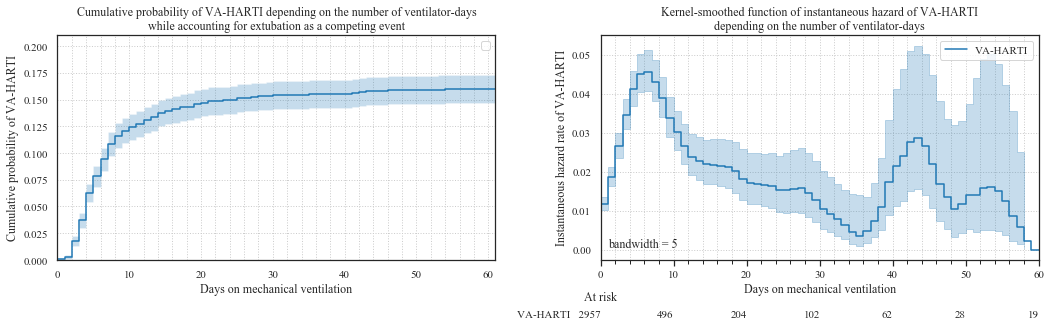

In [8]:
# define data
T = vae_data_main[['ID_subid', 'mech_vent_bid']].groupby('ID_subid').max()
E = vae_data_main[['ID_subid', 'vap']].groupby('ID_subid').max()

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15,5))

# Plot hazard function
BANDWIDTH = 5
LIM = 61
naf = NelsonAalenFitter()
naf.fit(T, E, timeline=range(0, LIM, 1), label='VA-HARTI')
naf.plot_hazard(ax=ax2, bandwidth=BANDWIDTH)
add_at_risk_counts(naf, ax=ax2)
ax2.text(1, 0.0005, 'bandwidth = '+ "%.0f" %BANDWIDTH, fontsize=12)
ax2.minorticks_on()
ax2.grid(linestyle='dotted', which='both', axis='x')
ax2.grid(linestyle='dotted')
ax2.set_ylabel('Instantaneous hazard rate of VA-HARTI')
ax2.set_xlabel('Days on mechanical ventilation')
ax2.set_title('Kernel-smoothed function of instantaneous hazard of VA-HARTI\ndepending on the number of ventilator-days')

# Plot competing event function
E = E.replace(0, 2)
cuminc_res = cuminc(T.values.reshape(-1), E.values.reshape(-1))

for name, group in list(cuminc_res.groups.items())[:1]:
    ax1.plot(group.time, group.est, label=name)
    ax1.fill_between(group.time, group.low_ci, group.high_ci, alpha=0.25)
    ax1.set_xlim(0, LIM, 1)

ax1.set_ylim(0, 0.21)
ax1.minorticks_on()
ax1.grid(linestyle='dotted', which='both', axis='x')
ax1.grid(linestyle='dotted')
ax1.legend('')
ax1.set_ylabel('Cumulative probability of VA-HARTI')
ax1.set_xlabel('Days on mechanical ventilation')
ax1.set_title('Cumulative probability of VA-HARTI depending on the number of ventilator-days\nwhile accounting for extubation as a competing event')
plt.tight_layout()
plt.savefig('./pictures/cuminc_VA_mechvent.pdf', dpi=600)

In [9]:
# Show estimate table from cuminc
df = []
for name, group in cuminc_res.groups.items():
    df.append(group.time)
    df.append(group.est)
    df.append(name)
    
harti = pd.DataFrame(zip(pd.Series(df[0]), pd.Series(df[1])))
print(harti.tail(10))

# Added risk at first 10 days
h8 = harti.iloc[1:18, :].groupby(0).max()
print('\nEach day adds probability: ', h8.diff().mean().values)

        0         1
82   54.0  0.159621
83   62.0  0.159621
84   62.0  0.159959
85   63.0  0.159959
86   63.0  0.160298
87   70.0  0.160298
88   70.0  0.160636
89  191.0  0.160636
90  191.0  0.160974
91  364.0  0.160974

Each day adds probability:  [0.01344268]


In [10]:
# Calculate doubling time for exponential phase VA-HARTI
v = harti.head(21).groupby(0).max()
rate = v.pct_change()[1].mean()
print("Doubling time, days: ", np.log(2) / np.log(1+rate))

Doubling time, days:  0.8449245646935954


_______